# Extract Data from yfinance

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:

df = yf.download('TSLA', 
                  start='2019-01-01', 
                  end='2024-4-29', 
                  progress=False)
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-22,140.559998,144.440002,138.800003,142.050003,142.050003,107097600
2024-04-23,143.330002,147.259995,141.110001,144.679993,144.679993,124545100
2024-04-24,162.839996,167.970001,157.509995,162.130005,162.130005,181178000
2024-04-25,158.960007,170.880005,158.360001,170.179993,170.179993,126427500
2024-04-26,168.850006,172.119995,166.369995,168.289993,168.289993,109815700


In [3]:
df['Date'] = df.index  # Create a new column 'Date' with the index values
df.reset_index(drop=True, inplace=True) 

In [4]:
close_df = df[['Date', 'Close']]

In [5]:
close_df.head()

,Date,Close
0,2019-01-02,20.674667
1,2019-01-03,20.024000
2,2019-01-04,21.179333
3,2019-01-07,22.330667
4,2019-01-08,22.356667


In [6]:
close_df_copy = close_df.copy()
close_df_copy = close_df_copy.drop('Date', axis = 1)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

scaler = scaler.fit(close_df_copy)
close_df_copy_scaled = scaler.transform(close_df_copy)

# Create a Window Function

In [8]:
X, y = [], []

window_size = 60
target = 1
for i in range(window_size, len(close_df_copy_scaled) - target + 1):
    X.append(close_df_copy_scaled[i - window_size: i, :])
    y.append(close_df_copy_scaled[i + target - 1:i + target, 0])
    
X, y = np.array(X), np.array(y)

In [9]:
print(X.shape, y.shape)

(1279, 60, 1) (1279, 1)


In [10]:
training_size=int(len(y)*0.8)
X_train, X_test = X[:training_size], X[training_size:]
y_train, y_test = y[:training_size], y[training_size:]

In [11]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1023, 60, 1) (256, 60, 1) (1023, 1) (256, 1)


In [12]:
def mse(preds, targets):
    return F.mse_loss(preds, targets)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def calculate_mape(actual, forecast):
    
    if len(actual) != len(forecast):
        raise ValueError("Length of actual and forecast lists must be the same")
    
    absolute_errors = [abs(actual[i] - forecast[i]) for i in range(len(actual))]
    percentage_errors = [absolute_errors[i] / actual[i] * 100 for i in range(len(actual))]
    mape = sum(percentage_errors) / len(actual)
    
    return mape


In [13]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim,
                        dropout=0, attention_axes=None):
 
  x = layers.LayerNormalization(epsilon=1e-6)(inputs)
  x = layers.MultiHeadAttention(
      key_dim=head_size, num_heads=num_heads, dropout=dropout,
      attention_axes=attention_axes
      )(x, x)
  x = layers.Dropout(dropout)(x)
  res = x + inputs

  x = layers.LayerNormalization(epsilon=1e-6)(res)
  x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
  x = layers.Dropout(dropout)(x)
  x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
  return x + res

def build_transfromer(head_size, 
                      num_heads,
                      ff_dim,
                      num_trans_blocks,
                      mlp_units, dropout=0, mlp_dropout=0) -> tf.keras.Model:

  n_timesteps, n_features, n_outputs = window_size, 1, 1
  inputs = tf.keras.Input(shape=(n_timesteps, n_features))
  x = inputs 
  for _ in range(num_trans_blocks):
    x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
  
  x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
  for dim in mlp_units:
    x = layers.Dense(dim, activation="relu")(x)
    x = layers.Dropout(mlp_dropout)(x)

  outputs = layers.Dense(n_outputs, activation='relu')(x)
  return tf.keras.Model(inputs, outputs)


In [15]:
import optuna
def objective(trial):
    
    
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 0.002)
    num_heads = trial.suggest_categorical('n_heads', [8,16, 24])
    head_size = trial.suggest_categorical('head_size', [128, 256, 512])
    ff_dim = trial.suggest_categorical('ff_dim', [2, 4, 8])
    
    print('Learning Rate', learning_rate)
    print('num_heads', num_heads)
    print('head_size', head_size)
    print('head_size', ff_dim)
    
    model = build_transfromer(head_size=head_size, num_heads=num_heads, ff_dim=ff_dim, 
                              num_trans_blocks=4, mlp_units=[256], 
                              mlp_dropout=0.10, dropout=0.2)
    
    checkpoint = ModelCheckpoint(f'tesla_model_transformer/model_tesla_window_60_{learning_rate}.h5', save_best_only=True)
    model.compile(loss='mean_squared_error',optimizer= Adam(learning_rate=learning_rate))
    model.fit(X_train, y_train, batch_size=32,epochs=400, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpoint])

    model_load = load_model(f'tesla_model_transformer/model_tesla_window_60_{learning_rate}.h5')
    test_predictions = model_load.predict(X_test)
    test_predictions = scaler.inverse_transform(test_predictions)
        
    y_test1 = scaler.inverse_transform(y_test)
        
    y_TEST = y_test1
    y_PRED = test_predictions
        
    #mae = mean_absolute_error(y_TEST[-256:], y_PRED[-256:])
    #RMSE = rmse(y_TEST[-256:], y_PRED[-256:])
    MAPE = calculate_mape(y_TEST[-256:], y_PRED[-256:])
    #r2 = r2_score(y_TEST[-256:], y_PRED[-256:])
    
    return MAPE

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials = 12)

trial = study.best_trial
print(trial)

[I 2024-05-14 09:59:45,832] A new study created in memory with name: no-name-4c229921-4b51-43d3-b955-01b4142b4bee


Learning Rate 0.0013200287238484397
num_heads 8
head_size 256
head_size 4
Epoch 1/400
32/32 [==============================] - 14s 66ms/step - loss: 0.0376 - val_loss: 0.0046
Epoch 2/400
32/32 [==============================] - 1s 37ms/step - loss: 0.0065 - val_loss: 0.0015
Epoch 3/400
32/32 [==============================] - 1s 37ms/step - loss: 0.0060 - val_loss: 0.0012
Epoch 4/400
32/32 [==============================] - 1s 38ms/step - loss: 0.0052 - val_loss: 0.0010
Epoch 5/400
32/32 [==============================] - 1s 32ms/step - loss: 0.0043 - val_loss: 0.0012
Epoch 6/400
32/32 [==============================] - 1s 35ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 7/400
32/32 [==============================] - 1s 44ms/step - loss: 0.0035 - val_loss: 0.0023
Epoch 8/400
32/32 [==============================] - 1s 36ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 9/400
32/32 [==============================] - 1s 41ms/step - loss: 0.0028 - val_loss: 7.2970e-04
Epoch 10/400
32/32 [=

[I 2024-05-14 10:07:04,773] Trial 0 finished with value: 2.5371930918843866 and parameters: {'learning_rate': 0.0013200287238484397, 'n_heads': 8, 'head_size': 256, 'ff_dim': 4}. Best is trial 0 with value: 2.5371930918843866.


Learning Rate 0.0014266675335208839
num_heads 16
head_size 256
head_size 8
Epoch 1/400
32/32 [==============================] - 6s 75ms/step - loss: 0.0317 - val_loss: 0.0035
Epoch 2/400
32/32 [==============================] - 2s 59ms/step - loss: 0.0090 - val_loss: 0.0018
Epoch 3/400
32/32 [==============================] - 2s 54ms/step - loss: 0.0069 - val_loss: 0.0022
Epoch 4/400
32/32 [==============================] - 2s 54ms/step - loss: 0.0068 - val_loss: 0.0044
Epoch 5/400
32/32 [==============================] - 2s 59ms/step - loss: 0.0052 - val_loss: 0.0016
Epoch 6/400
32/32 [==============================] - 2s 59ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 7/400
32/32 [==============================] - 2s 59ms/step - loss: 0.0030 - val_loss: 6.9152e-04
Epoch 8/400
32/32 [==============================] - 2s 54ms/step - loss: 0.0024 - val_loss: 7.1968e-04
Epoch 9/400
32/32 [==============================] - 2s 55ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 10/400
32/3

[I 2024-05-14 10:18:52,377] Trial 1 finished with value: 2.6687754377121697 and parameters: {'learning_rate': 0.0014266675335208839, 'n_heads': 16, 'head_size': 256, 'ff_dim': 8}. Best is trial 0 with value: 2.5371930918843866.


Learning Rate 0.0001662620564897953
num_heads 24
head_size 128
head_size 4
Epoch 1/400
32/32 [==============================] - 5s 64ms/step - loss: 0.0648 - val_loss: 0.0128
Epoch 2/400
32/32 [==============================] - 2s 48ms/step - loss: 0.0199 - val_loss: 0.0048
Epoch 3/400
32/32 [==============================] - 2s 49ms/step - loss: 0.0136 - val_loss: 0.0031
Epoch 4/400
32/32 [==============================] - 2s 49ms/step - loss: 0.0114 - val_loss: 0.0018
Epoch 5/400
32/32 [==============================] - 2s 48ms/step - loss: 0.0113 - val_loss: 0.0016
Epoch 6/400
32/32 [==============================] - 2s 48ms/step - loss: 0.0105 - val_loss: 0.0014
Epoch 7/400
32/32 [==============================] - 1s 43ms/step - loss: 0.0091 - val_loss: 0.0016
Epoch 8/400
32/32 [==============================] - 2s 48ms/step - loss: 0.0084 - val_loss: 0.0013
Epoch 9/400
32/32 [==============================] - 2s 48ms/step - loss: 0.0076 - val_loss: 0.0012
Epoch 10/400
32/32 [=====

[I 2024-05-14 10:28:30,333] Trial 2 finished with value: 2.87321688114932 and parameters: {'learning_rate': 0.0001662620564897953, 'n_heads': 24, 'head_size': 128, 'ff_dim': 4}. Best is trial 0 with value: 2.5371930918843866.


Learning Rate 0.001427546662401658
num_heads 8
head_size 512
head_size 4
Epoch 1/400
32/32 [==============================] - 5s 67ms/step - loss: 0.1463 - val_loss: 0.0689
Epoch 2/400
32/32 [==============================] - 2s 55ms/step - loss: 0.0173 - val_loss: 0.0065
Epoch 3/400
32/32 [==============================] - 2s 55ms/step - loss: 0.0089 - val_loss: 0.0017
Epoch 4/400
32/32 [==============================] - 2s 50ms/step - loss: 0.0074 - val_loss: 0.0051
Epoch 5/400
32/32 [==============================] - 2s 55ms/step - loss: 0.0065 - val_loss: 0.0012
Epoch 6/400
32/32 [==============================] - 2s 50ms/step - loss: 0.0075 - val_loss: 0.0020
Epoch 7/400
32/32 [==============================] - 2s 50ms/step - loss: 0.0053 - val_loss: 0.0016
Epoch 8/400
32/32 [==============================] - 2s 55ms/step - loss: 0.0054 - val_loss: 8.2745e-04
Epoch 9/400
32/32 [==============================] - 2s 50ms/step - loss: 0.0048 - val_loss: 9.1718e-04
Epoch 10/400
32/32 

[I 2024-05-14 10:39:31,843] Trial 3 finished with value: 2.6337325490426986 and parameters: {'learning_rate': 0.001427546662401658, 'n_heads': 8, 'head_size': 512, 'ff_dim': 4}. Best is trial 0 with value: 2.5371930918843866.


Learning Rate 0.0010025823126155232
num_heads 8
head_size 512
head_size 4
Epoch 1/400
32/32 [==============================] - 6s 67ms/step - loss: 0.2321 - val_loss: 0.2825
Epoch 2/400
32/32 [==============================] - 2s 50ms/step - loss: 0.2321 - val_loss: 0.2825
Epoch 3/400
32/32 [==============================] - 2s 50ms/step - loss: 0.2321 - val_loss: 0.2825
Epoch 4/400
32/32 [==============================] - 2s 50ms/step - loss: 0.2321 - val_loss: 0.2825
Epoch 5/400
32/32 [==============================] - 2s 50ms/step - loss: 0.2321 - val_loss: 0.2825
Epoch 6/400
32/32 [==============================] - 2s 50ms/step - loss: 0.2321 - val_loss: 0.2825
Epoch 7/400
32/32 [==============================] - 2s 50ms/step - loss: 0.2321 - val_loss: 0.2825
Epoch 8/400
32/32 [==============================] - 2s 50ms/step - loss: 0.2321 - val_loss: 0.2825
Epoch 9/400
32/32 [==============================] - 2s 50ms/step - loss: 0.2321 - val_loss: 0.2825
Epoch 10/400
32/32 [======

[I 2024-05-14 10:50:55,121] Trial 4 finished with value: 67.27509990883838 and parameters: {'learning_rate': 0.0010025823126155232, 'n_heads': 8, 'head_size': 512, 'ff_dim': 4}. Best is trial 0 with value: 2.5371930918843866.


Learning Rate 0.0017313979794996283
num_heads 8
head_size 512
head_size 2
Epoch 1/400
32/32 [==============================] - 6s 77ms/step - loss: 0.1423 - val_loss: 0.1722
Epoch 2/400
32/32 [==============================] - 2s 63ms/step - loss: 0.0376 - val_loss: 0.0687
Epoch 3/400
32/32 [==============================] - 2s 63ms/step - loss: 0.0192 - val_loss: 0.0592
Epoch 4/400
32/32 [==============================] - 2s 63ms/step - loss: 0.0138 - val_loss: 0.0415
Epoch 5/400
32/32 [==============================] - 2s 63ms/step - loss: 0.0110 - val_loss: 0.0162
Epoch 6/400
32/32 [==============================] - 2s 63ms/step - loss: 0.0094 - val_loss: 0.0158
Epoch 7/400
32/32 [==============================] - 2s 64ms/step - loss: 0.0077 - val_loss: 0.0078
Epoch 8/400
32/32 [==============================] - 2s 64ms/step - loss: 0.0058 - val_loss: 0.0031
Epoch 9/400
32/32 [==============================] - 2s 59ms/step - loss: 0.0059 - val_loss: 0.0103
Epoch 10/400
32/32 [======

[I 2024-05-14 11:03:39,317] Trial 5 finished with value: 2.5742522816165314 and parameters: {'learning_rate': 0.0017313979794996283, 'n_heads': 8, 'head_size': 512, 'ff_dim': 2}. Best is trial 0 with value: 2.5371930918843866.


Learning Rate 0.0005965052581808296
num_heads 8
head_size 128
head_size 8
Epoch 1/400
32/32 [==============================] - 5s 47ms/step - loss: 0.0166 - val_loss: 0.0063
Epoch 2/400
32/32 [==============================] - 1s 33ms/step - loss: 0.0069 - val_loss: 0.0016
Epoch 3/400
32/32 [==============================] - 1s 30ms/step - loss: 0.0063 - val_loss: 0.0060
Epoch 4/400
32/32 [==============================] - 1s 33ms/step - loss: 0.0050 - val_loss: 0.0010
Epoch 5/400
32/32 [==============================] - 1s 28ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 6/400
32/32 [==============================] - 1s 35ms/step - loss: 0.0031 - val_loss: 8.7362e-04
Epoch 7/400
32/32 [==============================] - 1s 31ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 8/400
32/32 [==============================] - 1s 33ms/step - loss: 0.0031 - val_loss: 8.5509e-04
Epoch 9/400
32/32 [==============================] - 1s 30ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 10/400
32/32

[I 2024-05-14 11:09:56,725] Trial 6 finished with value: 2.6468312246816503 and parameters: {'learning_rate': 0.0005965052581808296, 'n_heads': 8, 'head_size': 128, 'ff_dim': 8}. Best is trial 0 with value: 2.5371930918843866.


Learning Rate 0.0015734642135074722
num_heads 16
head_size 128
head_size 4
Epoch 1/400
32/32 [==============================] - 5s 57ms/step - loss: 0.1451 - val_loss: 0.0887
Epoch 2/400
32/32 [==============================] - 1s 42ms/step - loss: 0.0340 - val_loss: 0.0279
Epoch 3/400
32/32 [==============================] - 1s 37ms/step - loss: 0.0158 - val_loss: 0.0356
Epoch 4/400
32/32 [==============================] - 1s 42ms/step - loss: 0.0114 - val_loss: 0.0126
Epoch 5/400
32/32 [==============================] - 1s 37ms/step - loss: 0.0086 - val_loss: 0.0197
Epoch 6/400
32/32 [==============================] - 1s 42ms/step - loss: 0.0070 - val_loss: 0.0125
Epoch 7/400
32/32 [==============================] - 1s 42ms/step - loss: 0.0069 - val_loss: 0.0031
Epoch 8/400
32/32 [==============================] - 1s 37ms/step - loss: 0.0049 - val_loss: 0.0081
Epoch 9/400
32/32 [==============================] - 1s 37ms/step - loss: 0.0051 - val_loss: 0.0082
Epoch 10/400
32/32 [=====

[I 2024-05-14 11:17:59,546] Trial 7 finished with value: 2.649346021994397 and parameters: {'learning_rate': 0.0015734642135074722, 'n_heads': 16, 'head_size': 128, 'ff_dim': 4}. Best is trial 0 with value: 2.5371930918843866.


Learning Rate 0.0015633430182673148
num_heads 8
head_size 512
head_size 2
Epoch 1/400
32/32 [==============================] - 6s 76ms/step - loss: 0.0568 - val_loss: 0.0147
Epoch 2/400
32/32 [==============================] - 2s 59ms/step - loss: 0.0102 - val_loss: 0.0043
Epoch 3/400
32/32 [==============================] - 2s 59ms/step - loss: 0.0072 - val_loss: 0.0014
Epoch 4/400
32/32 [==============================] - 2s 57ms/step - loss: 0.0054 - val_loss: 0.0014
Epoch 5/400
32/32 [==============================] - 2s 56ms/step - loss: 0.0049 - val_loss: 8.3371e-04
Epoch 6/400
32/32 [==============================] - 2s 52ms/step - loss: 0.0041 - val_loss: 9.3947e-04
Epoch 7/400
32/32 [==============================] - 2s 64ms/step - loss: 0.0046 - val_loss: 6.8858e-04
Epoch 8/400
32/32 [==============================] - 2s 60ms/step - loss: 0.0028 - val_loss: 0.0015
Epoch 9/400
32/32 [==============================] - 2s 66ms/step - loss: 0.0029 - val_loss: 6.1118e-04
Epoch 10/4

[I 2024-05-14 11:29:46,874] Trial 8 finished with value: 2.5623959173938586 and parameters: {'learning_rate': 0.0015633430182673148, 'n_heads': 8, 'head_size': 512, 'ff_dim': 2}. Best is trial 0 with value: 2.5371930918843866.


Learning Rate 0.0015732377602500852
num_heads 24
head_size 256
head_size 4
Epoch 1/400
32/32 [==============================] - 7s 95ms/step - loss: 0.1710 - val_loss: 0.2032
Epoch 2/400
32/32 [==============================] - 3s 83ms/step - loss: 0.0475 - val_loss: 0.0441
Epoch 3/400
32/32 [==============================] - 2s 78ms/step - loss: 0.0212 - val_loss: 0.0640
Epoch 4/400
32/32 [==============================] - 3s 79ms/step - loss: 0.0148 - val_loss: 0.0554
Epoch 5/400
32/32 [==============================] - 3s 83ms/step - loss: 0.0137 - val_loss: 0.0193
Epoch 6/400
32/32 [==============================] - 3s 83ms/step - loss: 0.0111 - val_loss: 0.0186
Epoch 7/400
32/32 [==============================] - 3s 83ms/step - loss: 0.0087 - val_loss: 0.0086
Epoch 8/400
32/32 [==============================] - 3s 78ms/step - loss: 0.0075 - val_loss: 0.0093
Epoch 9/400
32/32 [==============================] - 3s 84ms/step - loss: 0.0063 - val_loss: 0.0018
Epoch 10/400
32/32 [=====

[I 2024-05-14 11:47:22,173] Trial 9 finished with value: 2.6404981707321515 and parameters: {'learning_rate': 0.0015732377602500852, 'n_heads': 24, 'head_size': 256, 'ff_dim': 4}. Best is trial 0 with value: 2.5371930918843866.


Learning Rate 0.0009253161746133234
num_heads 16
head_size 256
head_size 2
Epoch 1/400
32/32 [==============================] - 6s 77ms/step - loss: 0.0874 - val_loss: 0.0055
Epoch 2/400
32/32 [==============================] - 2s 61ms/step - loss: 0.0131 - val_loss: 0.0029
Epoch 3/400
32/32 [==============================] - 2s 60ms/step - loss: 0.0081 - val_loss: 0.0029
Epoch 4/400
32/32 [==============================] - 2s 60ms/step - loss: 0.0080 - val_loss: 0.0024
Epoch 5/400
32/32 [==============================] - 2s 60ms/step - loss: 0.0068 - val_loss: 0.0019
Epoch 6/400
32/32 [==============================] - 2s 54ms/step - loss: 0.0072 - val_loss: 0.0057
Epoch 7/400
32/32 [==============================] - 2s 60ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 8/400
32/32 [==============================] - 2s 63ms/step - loss: 0.0053 - val_loss: 0.0013
Epoch 9/400
32/32 [==============================] - 2s 63ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 10/400
32/32 [=====

[I 2024-05-14 11:59:47,259] Trial 10 finished with value: 2.62230877123515 and parameters: {'learning_rate': 0.0009253161746133234, 'n_heads': 16, 'head_size': 256, 'ff_dim': 2}. Best is trial 0 with value: 2.5371930918843866.


Learning Rate 0.0019722952704556334
num_heads 8
head_size 256
head_size 2
Epoch 1/400
32/32 [==============================] - 6s 54ms/step - loss: 0.1326 - val_loss: 0.0274
Epoch 2/400
32/32 [==============================] - 1s 41ms/step - loss: 0.0096 - val_loss: 0.0024
Epoch 3/400
32/32 [==============================] - 1s 40ms/step - loss: 0.0054 - val_loss: 0.0013
Epoch 4/400
32/32 [==============================] - 1s 35ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 5/400
32/32 [==============================] - 1s 35ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/400
32/32 [==============================] - 1s 40ms/step - loss: 0.0023 - val_loss: 9.3470e-04
Epoch 7/400
32/32 [==============================] - 1s 40ms/step - loss: 0.0019 - val_loss: 8.0254e-04
Epoch 8/400
32/32 [==============================] - 1s 35ms/step - loss: 0.0022 - val_loss: 0.0027
Epoch 9/400
32/32 [==============================] - 1s 40ms/step - loss: 0.0020 - val_loss: 7.3218e-04
Epoch 10/400
3

[I 2024-05-14 12:06:49,388] Trial 11 finished with value: 2.504636814609024 and parameters: {'learning_rate': 0.0019722952704556334, 'n_heads': 8, 'head_size': 256, 'ff_dim': 2}. Best is trial 11 with value: 2.504636814609024.


FrozenTrial(number=11, state=TrialState.COMPLETE, values=[2.504636814609024], datetime_start=datetime.datetime(2024, 5, 14, 11, 59, 47, 260376), datetime_complete=datetime.datetime(2024, 5, 14, 12, 6, 49, 387557), params={'learning_rate': 0.0019722952704556334, 'n_heads': 8, 'head_size': 256, 'ff_dim': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.002, log=False, low=0.0001, step=None), 'n_heads': CategoricalDistribution(choices=(8, 16, 24)), 'head_size': CategoricalDistribution(choices=(128, 256, 512)), 'ff_dim': CategoricalDistribution(choices=(2, 4, 8))}, trial_id=11, value=None)


In [16]:
model_load = load_model(f'tesla_model_transformer/model_tesla_window_60_0.0019722952704556334.h5') 

In [17]:
test_predictions = model_load.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)
    
y_test1 = scaler.inverse_transform(y_test)
    
y_TEST = y_test1
y_PRED = test_predictions
    
mae = mean_absolute_error(y_TEST[-256:], y_PRED[-256:])
RMSE = rmse(y_TEST[-256:], y_PRED[-256:])
MAPE = calculate_mape(y_TEST[-256:], y_PRED[-256:])
r2 = r2_score(y_TEST[-256:], y_PRED[-256:])

print("Mean Absolute Error (MAE):", mae)
print("RMSE",RMSE)
print("MAPE", MAPE)
print("R2", r2)

8/8 [==============================] - 1s 50ms/step
Mean Absolute Error (MAE): 5.443780720233917
RMSE 7.171455539336939
MAPE [2.50463681]
R2 0.9636742007920964


In [18]:
y_PRED_all_ = [i[0] for i in y_PRED]
y_TEST_ = [i[0] for i in y_TEST]

In [21]:
test_results = pd.DataFrame(data={'Predicted':y_PRED_all_, 'Actuals':y_TEST_, 'Date': close_df['Date'].iloc[-256:]})

In [22]:
test_results

,Predicted,Actuals,Date
1083,167.952286,165.080002,2023-04-21
1084,164.961838,162.550003,2023-04-24
1085,162.857803,160.669998,2023-04-25
1086,160.898071,153.750000,2023-04-26
1087,158.184479,160.190002,2023-04-27
...,...,...,...
1334,148.946472,142.050003,2024-04-22
1335,145.101761,144.679993,2024-04-23
1336,144.302124,162.130005,2024-04-24
1337,154.677460,170.179993,2024-04-25


In [23]:
test_results = test_results.set_index('Date')

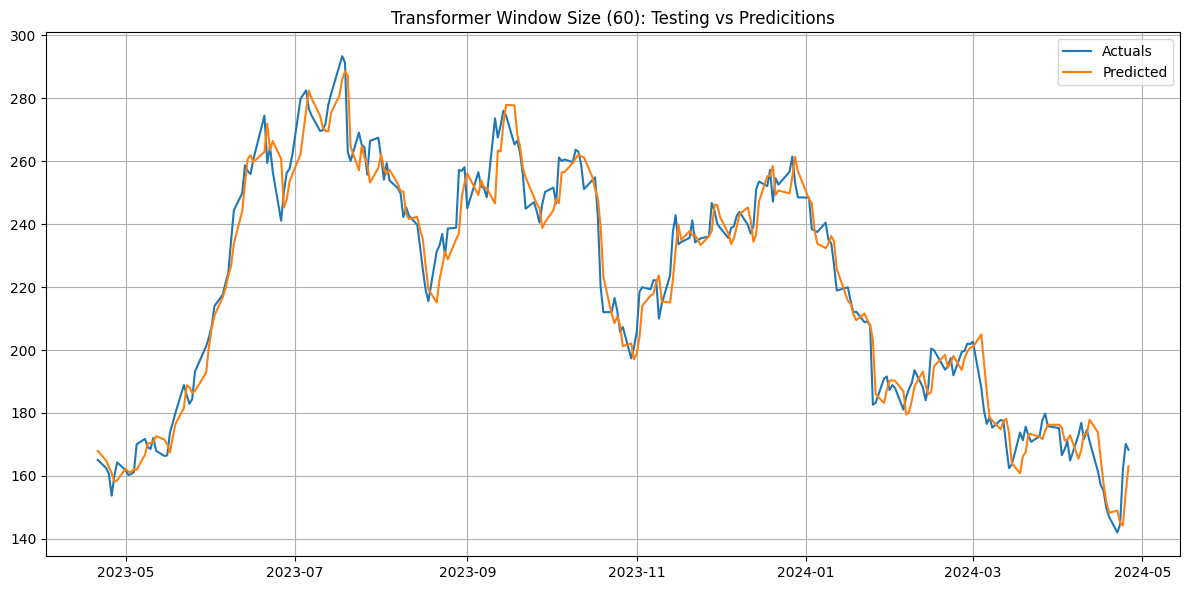

In [24]:
plt.figure(figsize=(12, 6))
#plt.plot(X_['Close'], label = 'Train')
plt.plot(test_results['Actuals'], label = 'Actuals')
plt.plot(test_results['Predicted'], label = 'Predicted')

plt.title('Transformer Window Size (60): Testing vs Predicitions')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

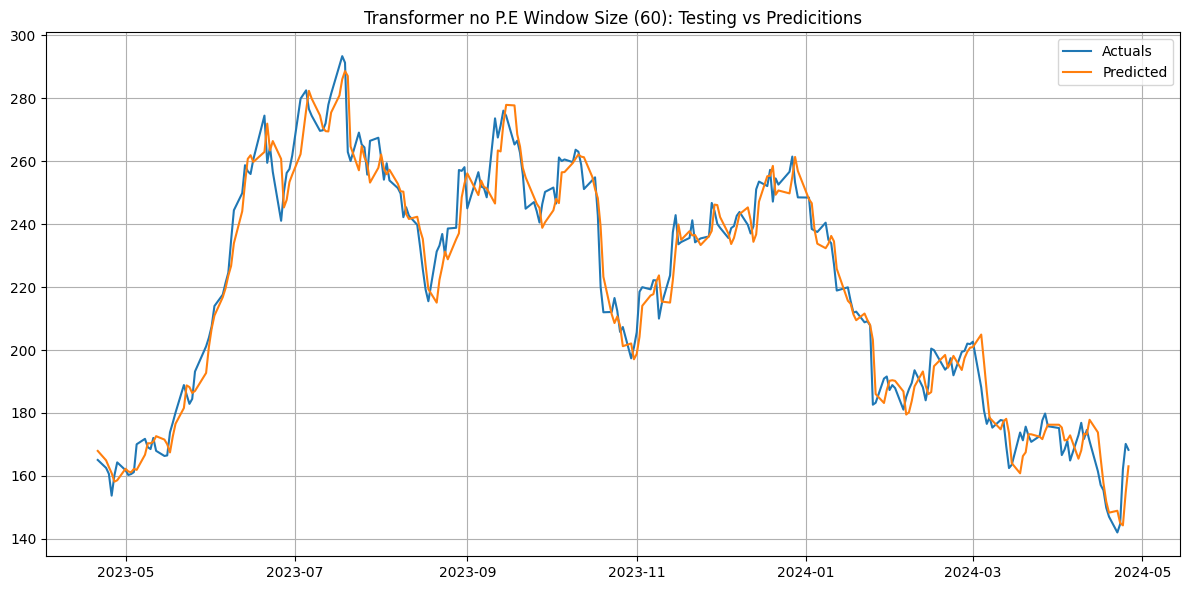

In [25]:
plt.figure(figsize=(12, 6))
#plt.plot(X_['Close'], label = 'Train')
plt.plot(test_results['Actuals'], label = 'Actuals')
plt.plot(test_results['Predicted'], label = 'Predicted')

plt.title('Transformer no P.E Window Size (60): Testing vs Predicitions')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()